# Background

This notebook will be exploring the viability of the dataset for use in ML through KNN, LR, & SVM. The reference for this ML Test is found in this [GitHub link](https://github.com/jm55/CSINTSY-MCO-5/blob/main/Machine%20Learning/notebook-v2.2.ipynb).

# Importing Libraries

In [1]:
import time, datetime
import numpy as np
import pandas as pd
import seaborn as sns

#Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.model_selection as model_selection

#Performance Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

#ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.ensemble import HistGradientBoostingClassifier as HGBT

#Automated Fine-Tuning
from sklearn.model_selection import GridSearchCV

# Importing Datasets

Note that these datasets that are being used are the ones already pre-processed by the notebook: `[Datasets] - Thesis Notebook.ipynb`

## 1. Reference APIs

For use later when transforming data from string APIs to numeric form to be compatible for use in ML training.

In [2]:
def getAPIs():
    apis = pd.read_csv('CombinedAPIs.csv', low_memory=False)
    apis = apis['api'].to_list()
    apis.append('nan') #Take note of this
    return apis
apis = getAPIs()

## 2. Setting Up Datasets

### 2.1. Loading MalbehavD, Catak, & Oliveira

In [3]:
malbehavd = pd.read_csv('MalbehavD_LabelEncoded.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEncoded.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEncoded.csv', low_memory=False)

#### 2.1.1 Preview MalbehavD

In [4]:
malbehavd.head()

,sha256,malware,0,1,2,3,4,5,6,7,...,165,166,167,168,169,170,171,172,173,174
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,26,2,66,53,30,32,45,38,...,0,0,0,0,0,0,0,0,0,0
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,35,19,66,10,79,93,47,2,...,0,0,0,0,0,0,0,0,0,0
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,14,7,27,36,35,78,95,23,...,0,0,0,0,0,0,0,0,0,0
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,39,31,36,96,67,44,86,55,...,0,0,0,0,0,0,0,0,0,0
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,26,23,61,95,105,84,57,54,...,0,0,0,0,0,0,0,0,0,0


#### 2.1.2. Preview Oliveira

In [5]:
oliveira.head()

,hash,malware,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,071e8c3f8922e186e57548cd4c703a5d,1,36,74,54,68,108,71,91,123,...,73,41,177,83,103,126,23,128,34,40
1,33f8e6d08a6aae939f25a8e0d63dd523,1,22,54,62,65,71,54,75,52,...,35,49,143,72,42,174,85,110,135,23
2,b68abd064e975e1c6d5f25e748663076,1,3,32,75,43,92,54,97,52,...,77,39,72,77,39,68,79,41,73,69
3,72049be7bd30ea61297ea624ae198067,1,22,54,62,65,71,54,75,52,...,129,122,180,126,182,109,128,185,141,177
4,c9b3700a77facf29172f32df6bc77f48,1,22,63,42,74,51,98,56,96,...,26,123,153,26,125,152,88,159,90,152


#### 2.1.3. Preview Catak

In [6]:
catak.head()

,malware_type,malware,0,1,2,3,4,5,6,7,...,156,157,158,159,160,161,162,163,164,165
0,Trojan,1,27,32,87,66,71,84,64,75,...,0,0,0,0,0,0,0,0,0,0
1,Trojan,1,19,39,54,41,45,118,67,54,...,0,0,0,0,0,0,0,0,0,0
2,Backdoor,1,25,32,22,2,99,109,106,96,...,0,0,0,0,0,0,0,0,0,0
3,Backdoor,1,27,32,87,66,71,84,64,75,...,0,0,0,0,0,0,0,0,0,0
4,Trojan,1,27,32,106,55,99,101,106,4,...,0,0,0,0,0,0,0,0,0,0


### 2.2. Determine Features/Attributes

Determine what features, or for our case, behaviors are associated in each ith API call of the executable.

In [7]:
def get_feats(malbehavd, oliveira, catak):
    malbehavd_feats = []
    for i in range(malbehavd.shape[1]-2):
        malbehavd_feats.append(str(i))
    oliveira_feats = []
    for i in range(oliveira.shape[1]-2):
        oliveira_feats.append(str(i))
    catak_feats = []
    for i in range(catak.shape[1]-2):
        catak_feats.append(str(i))
    return malbehavd_feats, oliveira_feats, catak_feats

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)

In [8]:
malbehavd[malbehavd_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,26,2,66,53,30,32,45,38,64,32,...,0,0,0,0,0,0,0,0,0,0
1,35,19,66,10,79,93,47,2,86,99,...,0,0,0,0,0,0,0,0,0,0
2,14,7,27,36,35,78,95,23,106,74,...,0,0,0,0,0,0,0,0,0,0
3,39,31,36,96,67,44,86,55,63,49,...,0,0,0,0,0,0,0,0,0,0
4,26,23,61,95,105,84,57,54,82,49,...,0,0,0,0,0,0,0,0,0,0


In [9]:
oliveira[oliveira_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,36,74,54,68,108,71,91,123,32,88,...,73,41,177,83,103,126,23,128,34,40
1,22,54,62,65,71,54,75,52,76,53,...,35,49,143,72,42,174,85,110,135,23
2,3,32,75,43,92,54,97,52,96,53,...,77,39,72,77,39,68,79,41,73,69
3,22,54,62,65,71,54,75,52,76,53,...,129,122,180,126,182,109,128,185,141,177
4,22,63,42,74,51,98,56,96,55,76,...,26,123,153,26,125,152,88,159,90,152


In [10]:
catak[catak_feats].head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,27,32,87,66,71,84,64,75,49,61,...,0,0,0,0,0,0,0,0,0,0
1,19,39,54,41,45,118,67,54,46,38,...,0,0,0,0,0,0,0,0,0,0
2,25,32,22,2,99,109,106,96,57,121,...,0,0,0,0,0,0,0,0,0,0
3,27,32,87,66,71,84,64,75,49,61,...,0,0,0,0,0,0,0,0,0,0
4,27,32,106,55,99,101,106,4,108,63,...,0,0,0,0,0,0,0,0,0,0


### 2.3. Determine Labels

Determine what are the different labels that the combined features will result into. For this case, it will be either malicious (1) or not malicious (0).

In [11]:
y = malbehavd['malware'].to_numpy()
labels = malbehavd['malware'].unique()
print("MalbehavD - No. of unique labels: ", labels.size)
print(labels)

MalbehavD - No. of unique labels:  2
[0 1]


In [12]:
y = oliveira['malware'].to_numpy()
labels = oliveira['malware'].unique()
print("Oliviera - No. of unique labels: ", labels.size)
print(labels)

Oliviera - No. of unique labels:  2
[1 0]


In [13]:
y = catak['malware'].to_numpy()
labels = catak['malware'].unique()
print("Catak - No. of unique labels: ", labels.size)
print(labels)

Catak - No. of unique labels:  1
[1]


## 3. Dataset Selector
To automate the selection process as suppose to hard-coding changes, a dataset selector is made.

Simply change the input parameter for the `dataset_selector(dataset:int)`. The choices are:
- 0 - MalbehavD
- 1 - Oliveira
- 2 - Catak

In [14]:
def dataset_selector(dataset:int):
    global malbehavd
    global oliveira
    global catak
    global malbehavd_feats
    global oliveira_feats
    global catak_feats
    if dataset == 0:
        return malbehavd[malbehavd_feats], malbehavd['malware'].to_numpy()
    elif dataset == 1:
        return oliveira[oliveira_feats], oliveira['malware'].to_numpy()
    elif dataset == 2:
        return catak[catak_feats], catak['malware'].to_numpy()
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

## 4. Divide Training Data from Test Data

Divide the dataset into training and test data. For this test, it will be divided into 80:20 for train:test respectively.

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.20, random_state=1)

## 5. Others

In [16]:
cr = [] #Classification reports list; Entries as ['algo_label',algo_cr]
cm = [] #Confusion matrices list; Entries as ['algo_label', algo_cf]

# ML Proper

### ML Algorithms used:
1. K-Nearest Neighbors (KNN)
2. Logistic Regression (LR)
3. Decision Tree (DT/DTC)
4. Support Vector Machine (SVM)*
5. Random Forest (RF)*
6. Gaussian Naive Bayes (GNB)*
7. AdaBoost*
8. Multi-layer Perceptron (MLP)*
9. Gradient Tree Boosting*
10. Histogram-based Gradient Boosting Classification Tree*

*Newly Implemented

AdaBoost, despite being a boosted model like XGBoost and LGBM, is actually an old boosted model, being created way back in 1995. For reference here is the summary table of the different known boosted ML algorithms:

| Algorithm                      | AdaBoost                    | XGBoost                     | CatBoost                                    | LightGBM                    |
|--------------------------------|-----------------------------|-----------------------------|---------------------------------------------|-----------------------------|
| Year                           | 1995                        | 2014                        | 2017                                        | 2017                        |
| Handling Categorical Variables | No (Conversion is required) | No (Conversion is required) | Automatically handles categorical variables | No (Conversion is required) |
| Memory Usage                   | Low                         | Moderate                    | High                                        | Low                         |
| Parallel Processing            | No                          | Yes                         | Yes                                         | Yes                         |
| GPU Support                    | No                          | Yes                         | Yes                                         | Yes                         |
| Regularization                 | No                          | Yes                         | Yes                                         | Yes                         |
| Speed/Scalability              | Fast                        | Fast                        | Moderate                                    | Fast                        |

### Reference:
- [Boosted Algorithms](https://www.geeksforgeeks.org/gradientboosting-vs-adaboost-vs-xgboost-vs-catboost-vs-lightgbm/)
- [SciKit Learn](https://scikit-learn.org/stable/supervised_learning.html)

## 4. K-Nearest Neighbors

### 4.1 Load, Train/Fit, and Test/Evaluate K Neighbors Classifier Model

In [17]:
knn = KNeighborsClassifier(n_jobs=-1) #default: neighbors = 5, p = 2, leaf size = 30
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

### 4.2 Create Classifier Report

In [18]:
knn_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['KNN', knn_cr])
print(knn_cr)

              precision    recall  f1-score   support

           0     0.8007    0.9357    0.8630       249
           1     0.9283    0.7811    0.8484       265

    accuracy                         0.8560       514
   macro avg     0.8645    0.8584    0.8557       514
weighted avg     0.8665    0.8560    0.8554       514



### 4.3 K-NN Confusion Matrix

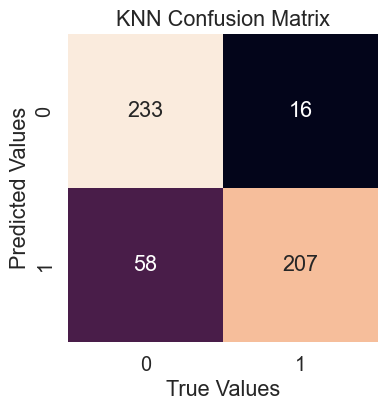

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
knn_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['KNN', knn_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("KNN Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 5. Decision Trees Classifier (DTC)

### 5.1. Load, Train/Fit, and Test/Evaluate Decision Tree Classifier Model

In [20]:
dtc = DecisionTreeClassifier(random_state=1) #default: no max depth
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)

### 5.2. Plot Decision Tree

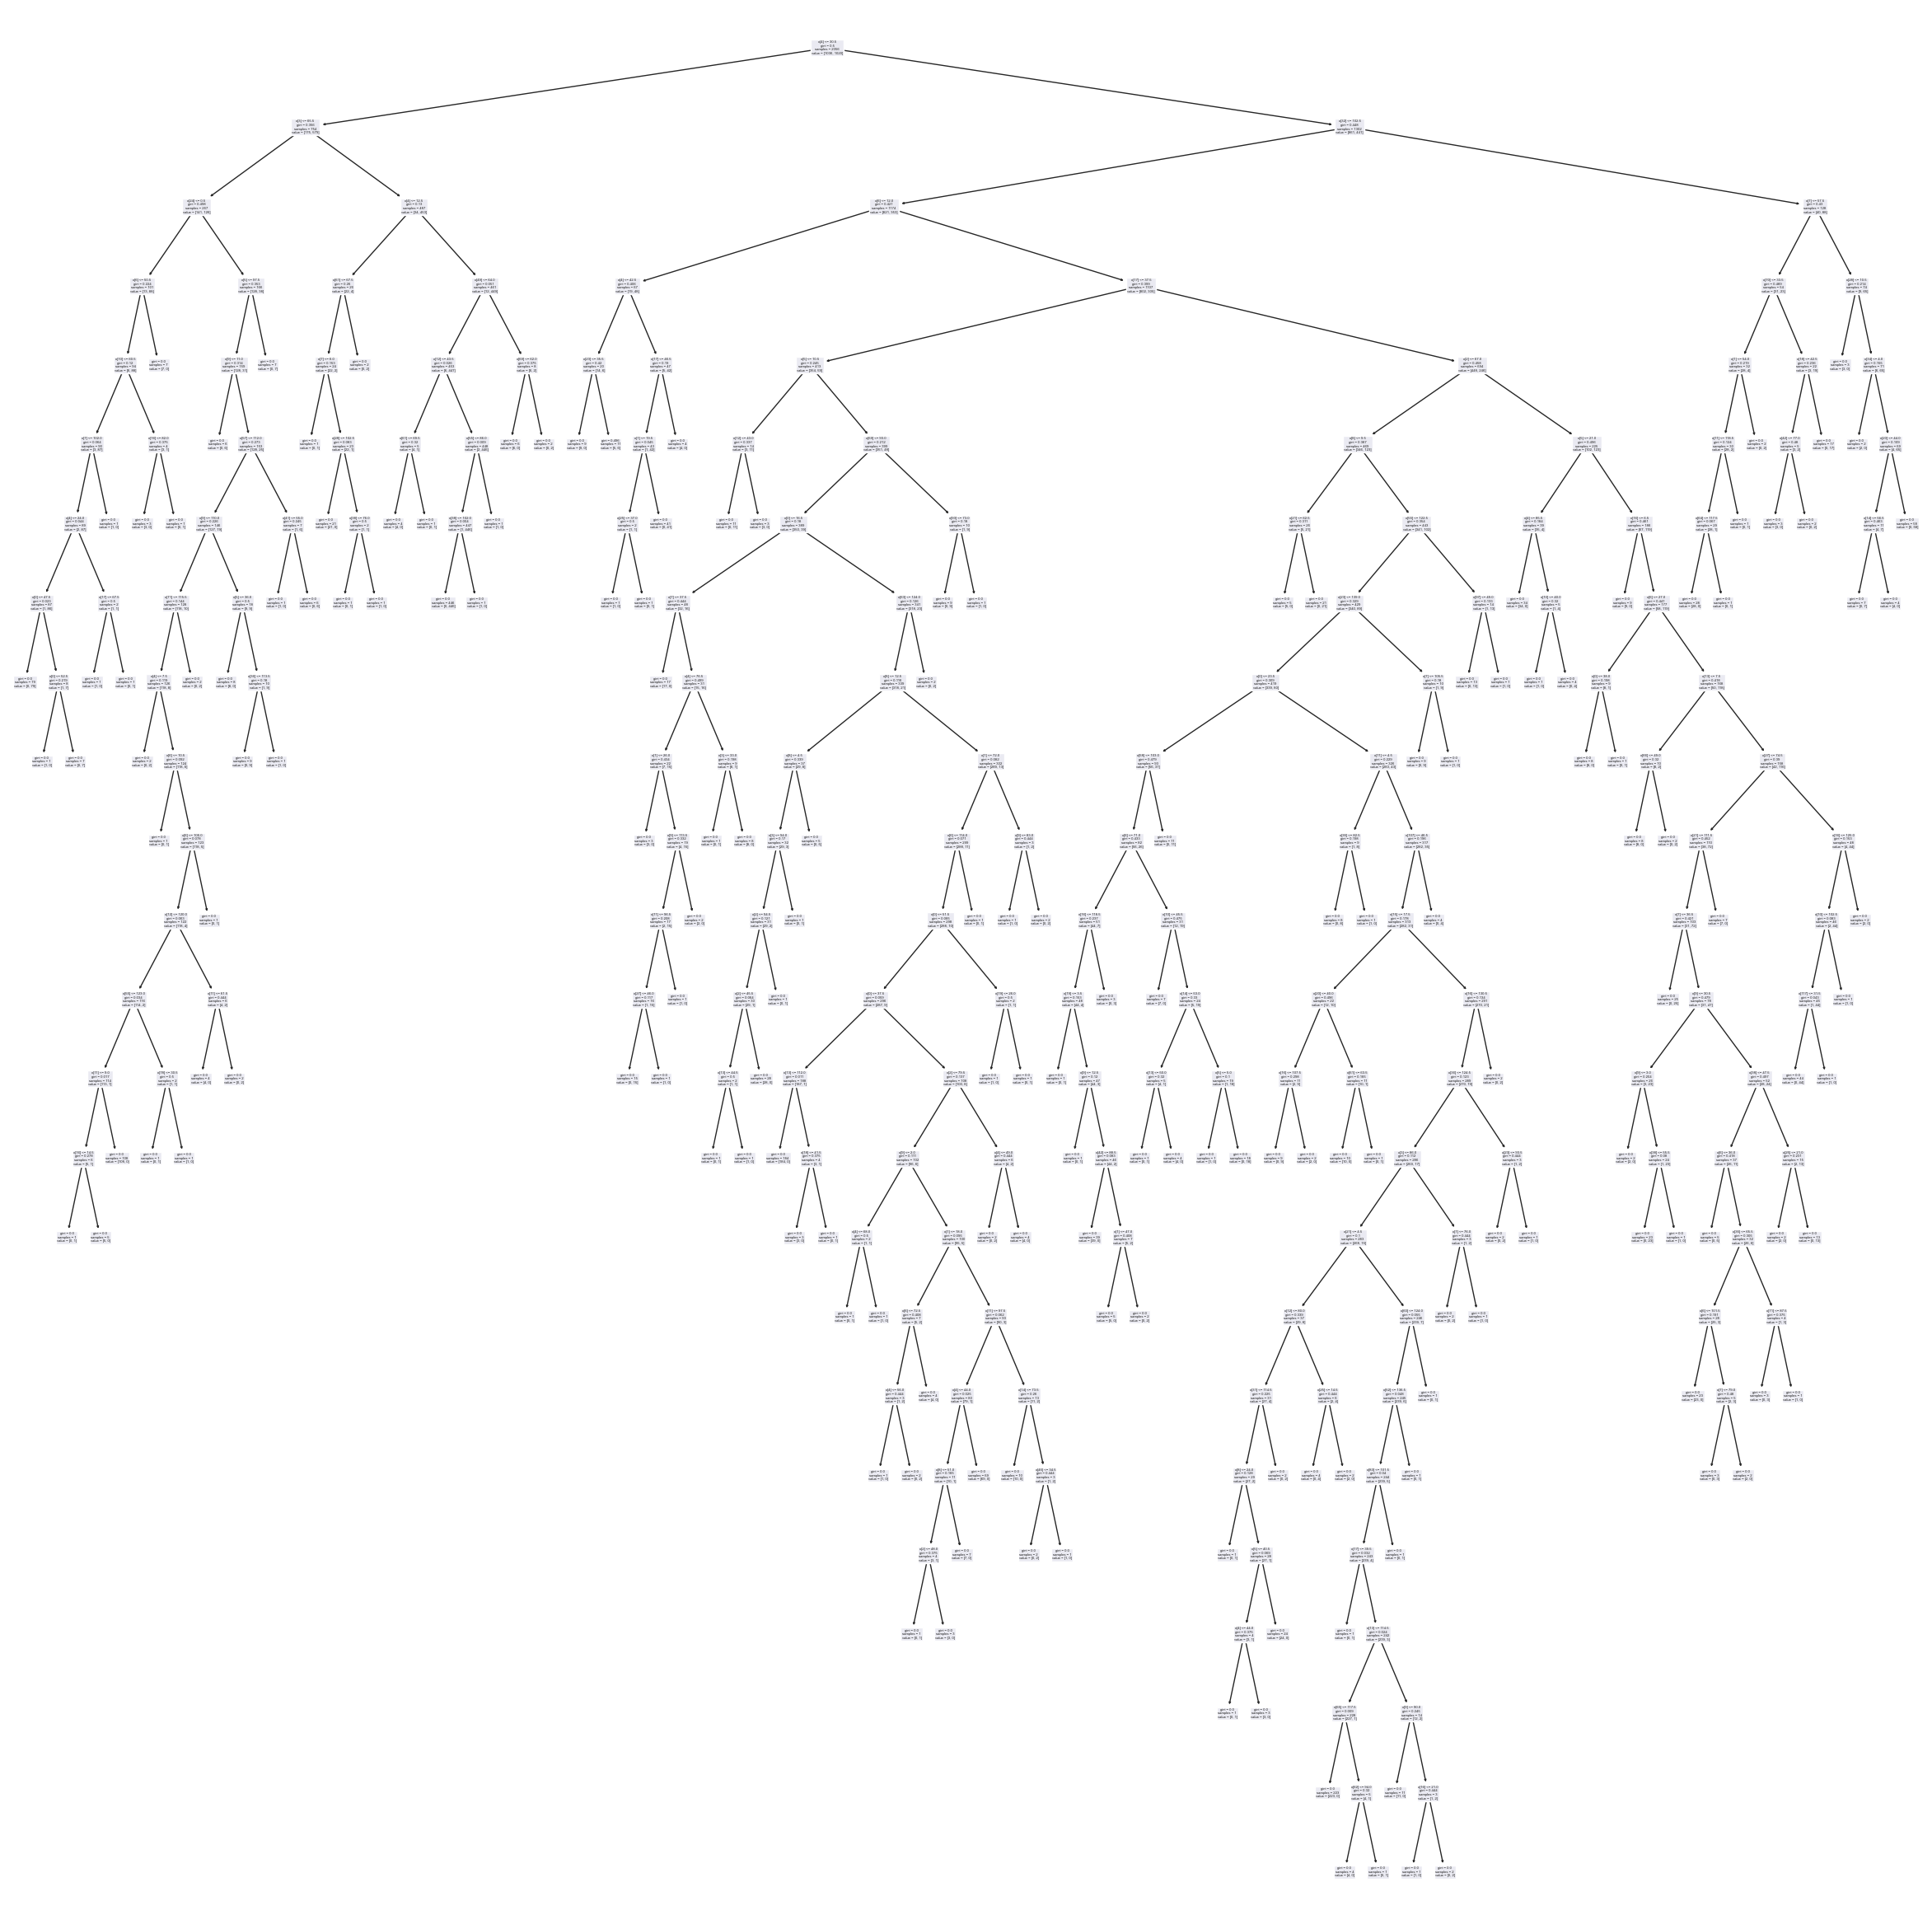

In [21]:
plt.figure(figsize=(30, 30))
plot_tree(dtc)
plt.show()

### 5.3. Create Classifier Report

In [22]:
dtc_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['DTC', dtc_cr])
print(dtc_cr)

              precision    recall  f1-score   support

           0     0.8730    0.8554    0.8641       249
           1     0.8667    0.8830    0.8748       265

    accuracy                         0.8696       514
   macro avg     0.8698    0.8692    0.8694       514
weighted avg     0.8697    0.8696    0.8696       514



### 5.4. DTC Confusion Matrix

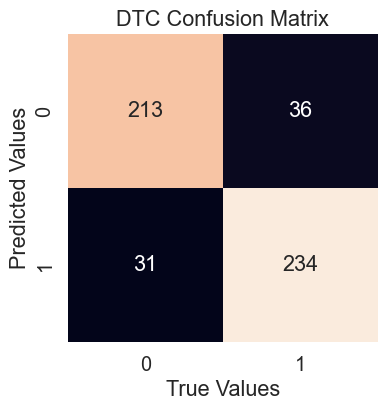

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
dtc_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['DTC', dtc_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("DTC Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 6. Logistic Regression

### 6.1. Load, Train/Fit, and Test/Evaluate Logistic Regression Classifier Model

In [24]:
lr = LogisticRegression(n_jobs=-1, random_state=1) #default: solver = lbfgs
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

### 6.2. Create Classification Report

In [25]:
lr_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['LR', lr_cr])
print(lr_cr)

              precision    recall  f1-score   support

           0     0.7148    0.7952    0.7529       249
           1     0.7848    0.7019    0.7410       265

    accuracy                         0.7471       514
   macro avg     0.7498    0.7485    0.7469       514
weighted avg     0.7509    0.7471    0.7468       514



### 6.3. LR Confusion Matrix

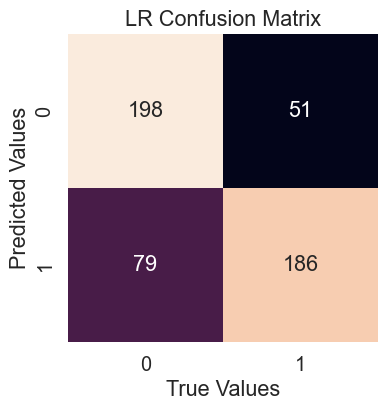

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
lr_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['LR', lr_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("LR Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 7. Support Vector Machine (SVM)*

### 7.1. Load, Train/Fit, and Test/Evaluate SVM Classifier Model

In [27]:
svm = SVM(random_state=1)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

### 7.2. Create Classification Report

In [28]:
svm_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['SVM', svm_cr])
print(svm_cr)

              precision    recall  f1-score   support

           0     0.7613    0.9478    0.8444       249
           1     0.9363    0.7208    0.8145       265

    accuracy                         0.8307       514
   macro avg     0.8488    0.8343    0.8294       514
weighted avg     0.8515    0.8307    0.8290       514



### 7.3. SVM Confusion Matrix

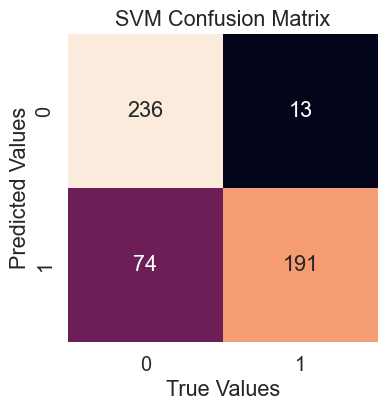

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
svm_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['SVM', svm_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("SVM Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 8. Random Forest*

### 8.1. Load, Train/Fit, and Test/Evaluate RF Classifier Model

In [30]:
rf = RF(random_state=1, n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

### 8.2. Create Classification Report

In [31]:
rf_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['RF', rf_cr])
print(rf_cr)

              precision    recall  f1-score   support

           0     0.8464    0.9960    0.9151       249
           1     0.9955    0.8302    0.9053       265

    accuracy                         0.9105       514
   macro avg     0.9209    0.9131    0.9102       514
weighted avg     0.9233    0.9105    0.9101       514



### 8.3. RF Confusion Matrix

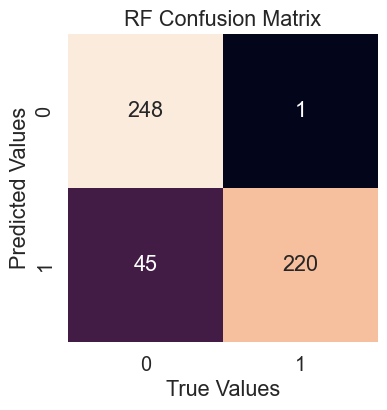

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
rf_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['RF', rf_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("RF Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 9. GNB*

### 9.1. Load, Train/Fit, and Test/Evaluate GNB Classifier Model

In [33]:
gnb = GNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

### 9.2. Create Classification Report

In [34]:
gnb_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['GNB', gnb_cr])
print(gnb_cr)

              precision    recall  f1-score   support

           0     0.6190    0.0522    0.0963       249
           1     0.5213    0.9698    0.6781       265

    accuracy                         0.5253       514
   macro avg     0.5702    0.5110    0.3872       514
weighted avg     0.5687    0.5253    0.3963       514



### 9.3. GNB Confusion Matrix

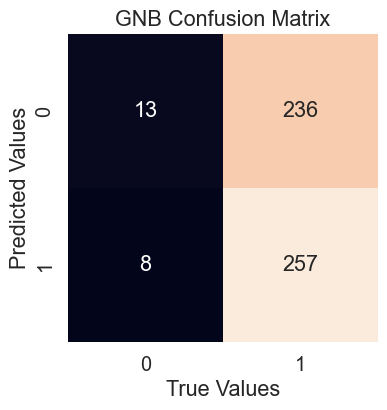

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
gnb_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['GNB', gnb_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("GNB Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 10. AdaBoost*

### 10.1. Load, Train/Fit, and Test/Evaluate AdaBoost Classifier Model

In [36]:
ada = ADA(random_state=1)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)

### 10.2. Create Classification Report

In [37]:
ada_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['AdaBoost', ada_cr])
print(ada_cr)

              precision    recall  f1-score   support

           0     0.8333    0.9036    0.8671       249
           1     0.9016    0.8302    0.8644       265

    accuracy                         0.8658       514
   macro avg     0.8675    0.8669    0.8657       514
weighted avg     0.8685    0.8658    0.8657       514



### 10.3. AdaBoost Confusion Matrix

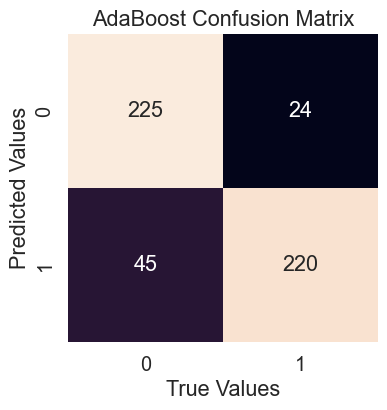

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
ada_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['AdaBoost', ada_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 11. MLP*

*Sort of a Neural Network like ML model.*

### 11.1. Load, Train/Fit, and Test/Evaluate MLP Classifier Model

In [39]:
mlp = MLP(random_state=1)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

### 11.2. Create Classification Report

In [40]:
mlp_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['MLP', mlp_cr])
print(mlp_cr)

              precision    recall  f1-score   support

           0     0.8231    0.9157    0.8669       249
           1     0.9114    0.8151    0.8606       265

    accuracy                         0.8638       514
   macro avg     0.8672    0.8654    0.8637       514
weighted avg     0.8686    0.8638    0.8636       514



### 11.3. MLP Confusion Matrix

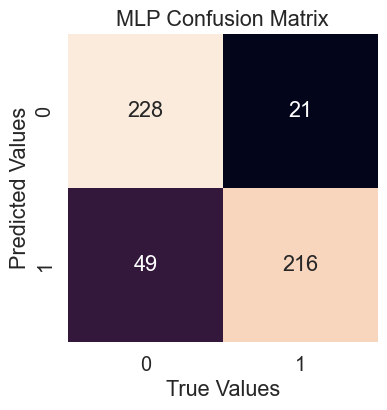

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
mlp_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['MLP', mlp_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("MLP Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 12. Gradient Tree Boosting

### 12.1. Load, Train/Fit, and Test/Evaluate GBT Classifier Model

In [42]:
gbt = GBT(random_state=1)
gbt.fit(X_train,y_train)
y_pred = gbt.predict(X_test)


### 12.2. Create Classification Report

In [43]:
gbt_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['GBT', gbt_cr])
print(gbt_cr)

              precision    recall  f1-score   support

           0     0.8691    0.9598    0.9122       249
           1     0.9582    0.8642    0.9087       265

    accuracy                         0.9105       514
   macro avg     0.9136    0.9120    0.9105       514
weighted avg     0.9150    0.9105    0.9104       514



### 12.3. GBT Confusion Matrix

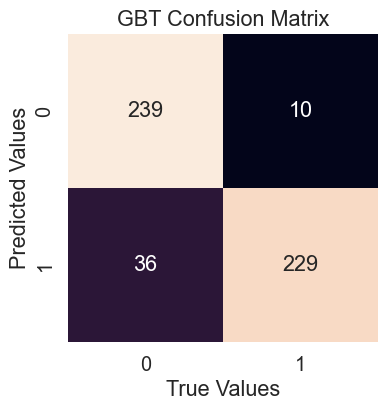

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
gbt_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['GBT', gbt_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("GBT Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 13. Histogram Gradient Tree Boosting
*According to SKLearn's documentation, the model was inspired by LightGBM*

### 13.1. Load, Train/Fit, and Test/Evaluate HGBT Classifier Model

In [45]:
hgbt = HGBT(random_state=1)
hgbt.fit(X_train,y_train)
y_pred = hgbt.predict(X_test)

### 13.2. Create Classification Report

In [46]:
hgbt_cr = classification_report(y_test, y_pred, digits=4)
cr.append(['HGBT', hgbt_cr])
print(hgbt_cr)

              precision    recall  f1-score   support

           0     0.8817    0.9880    0.9318       249
           1     0.9872    0.8755    0.9280       265

    accuracy                         0.9300       514
   macro avg     0.9345    0.9317    0.9299       514
weighted avg     0.9361    0.9300    0.9298       514



### 13.3. HGBT Confusion Matrix

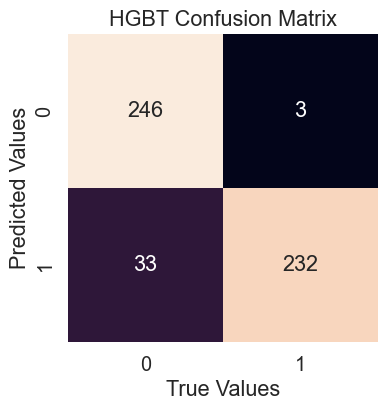

In [47]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)
hgbt_conf_matrix = classification_report(y_test,y_pred, digits=4)
cm.append(['HGBT', hgbt_conf_matrix])

plt.figure(figsize=(4,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_matrix_df, cbar=False, annot=True, fmt=".0f")
plt.title("HGBT Confusion Matrix")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

## 14. Comparison of Machine Learning Models

### 14.1 Using SkLearn's Classifier Report

In [48]:
for report in cr:
    print(report[0],"\n",report[1])

KNN 
               precision    recall  f1-score   support

           0     0.8007    0.9357    0.8630       249
           1     0.9283    0.7811    0.8484       265

    accuracy                         0.8560       514
   macro avg     0.8645    0.8584    0.8557       514
weighted avg     0.8665    0.8560    0.8554       514

DTC 
               precision    recall  f1-score   support

           0     0.8730    0.8554    0.8641       249
           1     0.8667    0.8830    0.8748       265

    accuracy                         0.8696       514
   macro avg     0.8698    0.8692    0.8694       514
weighted avg     0.8697    0.8696    0.8696       514

LR 
               precision    recall  f1-score   support

           0     0.7148    0.7952    0.7529       249
           1     0.7848    0.7019    0.7410       265

    accuracy                         0.7471       514
   macro avg     0.7498    0.7485    0.7469       514
weighted avg     0.7509    0.7471    0.7468       514

SV

### 14.2. Using Confusion Matrix

In [49]:
for matrix in cm:
    print(matrix[0],"\n",matrix[1])

KNN 
               precision    recall  f1-score   support

           0     0.8007    0.9357    0.8630       249
           1     0.9283    0.7811    0.8484       265

    accuracy                         0.8560       514
   macro avg     0.8645    0.8584    0.8557       514
weighted avg     0.8665    0.8560    0.8554       514

DTC 
               precision    recall  f1-score   support

           0     0.8730    0.8554    0.8641       249
           1     0.8667    0.8830    0.8748       265

    accuracy                         0.8696       514
   macro avg     0.8698    0.8692    0.8694       514
weighted avg     0.8697    0.8696    0.8696       514

LR 
               precision    recall  f1-score   support

           0     0.7148    0.7952    0.7529       249
           1     0.7848    0.7019    0.7410       265

    accuracy                         0.7471       514
   macro avg     0.7498    0.7485    0.7469       514
weighted avg     0.7509    0.7471    0.7468       514

SV

### 14.3 K-Folds Test Function

For this example, StratifiedKFold will be used to as suppose to the normal K-Folds in order *"to ensure that relative class frequencies are effectively sustained in each train and validation fold when using stratified sampling rather than random sampling"*.

**Reference:**

Prusty, S., Patnaik, S., & Dash, S. K. (2022). *SKCV: Stratified K-fold cross-validation on ML classifiers for predicting cervical cancer*. Frontiers in Nanotechnology, 4. https://www.frontiersin.org/articles/10.3389/fnano.2022.972421

In [50]:
splits = 10
kf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
model_label = ["KNN", "DTC", "LR", "SVM", "RF", "GNB", "AdaB", "MLP", "GBT", "HGBT"] #Don't change ordering
models = [knn, dtc, lr, svm, rf, gnb, ada, mlp, gbt, hgbt]
metric_label = ["Accuracy", "F1-Score (Weighted)", "Precision", "Recall", "ROC_AUC"]

def header():
    print(f"-----------------------------------------------------------------------------------------------")
    print(f"Fold   KNN      DTC      LR       SVM      RF       GNB      AdaB     MLP      GBT      HGBT   ")
    print(f"-----------------------------------------------------------------------------------------------")

def print_results(kfold_results, splits):
    header()
    for m in range(len(metric_label)): #Per Metric
        ave = [0,0,0,0,0,0,0,0,0,0] #Per model basis
        print("Metric:", metric_label[m])
        print("PER FOLD")
        for k in kfold_results: #Per Model
            out = ""
            for ksub in range(len(k)): #Per Fold of Model
                if ksub == 0:
                    out += f"{k[ksub]}      "
                else:
                    out += f"{k[ksub][m]:.4f}   "
                    ave[ksub-1] += k[ksub][m]
            print(out)
        out = "AVE    "
        print("AVERAGE")
        for a in ave:
            average = (a/splits)
            out += (f"{average:.4f}   ")
        print(out)
        print("")
    
def kfolds(X,y):
    global model_label
    global models
    global splits
    total_test_index = 0
    kfold_results = []
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        sublist = [i]
        axis = 0 

        # Extract from the dataframe based on the given indeces
        training_set = np.take(X, train_index, axis)
        training_set_labels = np.take(y, train_index, axis)
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)

        total_test_index += len(test_set)
        
        for m in range(len(models)):
            print(f"{datetime.datetime.now()} Fold {i}: {model_label[m]} Running...")
            startTime = time.time()
            models[m].fit(training_set,training_set_labels)
            train_timers[m] += time.time()-startTime
            startTime = time.time()
            m_pred = models[m].predict(test_set)
            predict_timers[m] += time.time()-startTime
            sublist.append([round(accuracy_score(test_set_labels, m_pred),4),
                            round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                            round(precision_score(test_set_labels, m_pred,zero_division=0),4),
                            round(recall_score(test_set_labels, m_pred),4),
                            round(roc_auc_score(test_set_labels, m_pred),4)
                           ])
        kfold_results.append(sublist)
        print(f"{datetime.datetime.now()} Fold {i:0.0f}: FINISHED")
    
    print("")
    print_results(kfold_results, splits)
    header()
    
    print("")
    print("Average Model Training Speed:")
    for train in range(len(train_timers)):
        train_timers[train] = [model_label[train], train_timers[train]/10]
    for t in train_timers:
        print(f"{t[0]:8s}: {t[1]:.4f}s")
    print("")
    
    print("Average Model Prediction Speed:")
    for predict in range(len(predict_timers)):
        predict_timers[predict] = [model_label[predict], predict_timers[predict]/total_test_index/10*1000]
    for p in predict_timers:
        print(f"{p[0]:8s}: {p[1]:.4f}ms")
    print("")

#### 14.3.1. Using Stratified K-Folds Cross Validation comparision for ML Algorithms (MalbehavD/Primary Dataset)

The dataset to use here will be `X,y` which is the primary dataset. 

In [51]:
train_timers = [0,0,0,0,0,0,0,0,0,0]
predict_timers = [0,0,0,0,0,0,0,0,0,0]
kfolds(X,y)

2023-08-22 13:30:51.224771 Fold 0: KNN Running...
2023-08-22 13:30:51.300150 Fold 0: DTC Running...
2023-08-22 13:30:51.433695 Fold 0: LR Running...
2023-08-22 13:30:53.577477 Fold 0: SVM Running...
2023-08-22 13:30:53.989719 Fold 0: RF Running...
2023-08-22 13:30:54.466054 Fold 0: GNB Running...
2023-08-22 13:30:54.489076 Fold 0: AdaB Running...
2023-08-22 13:30:55.116797 Fold 0: MLP Running...
2023-08-22 13:30:58.124841 Fold 0: GBT Running...
2023-08-22 13:31:00.270112 Fold 0: HGBT Running...
2023-08-22 13:31:08.320735 Fold 0: FINISHED
2023-08-22 13:31:08.325736 Fold 1: KNN Running...
2023-08-22 13:31:08.411262 Fold 1: DTC Running...
2023-08-22 13:31:08.565794 Fold 1: LR Running...
2023-08-22 13:31:10.710525 Fold 1: SVM Running...
2023-08-22 13:31:11.139668 Fold 1: RF Running...
2023-08-22 13:31:11.615027 Fold 1: GNB Running...
2023-08-22 13:31:11.642028 Fold 1: AdaB Running...
2023-08-22 13:31:12.277704 Fold 1: MLP Running...
2023-08-22 13:31:15.961141 Fold 1: GBT Running...
2023-08

#### 14.3.2. Using Stratified K-Folds Cross Validation comparision for ML Algorithms (Oliveira/Secondary Dataset)

The dataset to use here will be `A,b` which is the secondary dataset. 

In [52]:
train_timers = [0,0,0,0,0,0,0,0,0,0]
predict_timers = [0,0,0,0,0,0,0,0,0,0]
kfolds(A,b)

2023-08-22 13:33:41.126229 Fold 0: KNN Running...
2023-08-22 13:33:48.810199 Fold 0: DTC Running...
2023-08-22 13:33:52.747449 Fold 0: LR Running...
2023-08-22 13:34:02.911471 Fold 0: SVM Running...
2023-08-22 13:34:48.048928 Fold 0: RF Running...
2023-08-22 13:34:53.194576 Fold 0: GNB Running...
2023-08-22 13:34:53.297442 Fold 0: AdaB Running...
2023-08-22 13:35:00.277572 Fold 0: MLP Running...
2023-08-22 13:35:31.875844 Fold 0: GBT Running...
2023-08-22 13:35:56.594010 Fold 0: HGBT Running...
2023-08-22 13:36:02.692053 Fold 0: FINISHED
2023-08-22 13:36:02.727588 Fold 1: KNN Running...
2023-08-22 13:36:10.105748 Fold 1: DTC Running...
2023-08-22 13:36:14.329460 Fold 1: LR Running...
2023-08-22 13:36:24.443689 Fold 1: SVM Running...
2023-08-22 13:37:07.941062 Fold 1: RF Running...
2023-08-22 13:37:13.009838 Fold 1: GNB Running...
2023-08-22 13:37:13.110832 Fold 1: AdaB Running...
2023-08-22 13:37:20.118953 Fold 1: MLP Running...
2023-08-22 13:38:01.956632 Fold 1: GBT Running...
2023-08

### 14.4. Model Robustness Test

This will determine which dataset is more robust to use by training on one and testing on another.

In [53]:
def train_test(X,y,A,b):
    global model_label
    global models
    global metric_label
    results = []
    #Training models
    for m in range(len(models)):
        print(f"{datetime.datetime.now()} {model_label[m]} Running...")
        models[m].fit(X,y)
        m_pred = models[m].predict(A)
        print(f"{datetime.datetime.now()} {model_label[m]} Finished")
        results.append([model_label[m], 
                        [round(accuracy_score(b, m_pred),4),
                         round(f1_score(b, m_pred, average='weighted'),4),
                         round(precision_score(b, m_pred,zero_division=0),4),
                         round(recall_score(b, m_pred),4),
                         round(roc_auc_score(b, m_pred),4)
                        ]])
    print("")
    print(f"{'Model':6s}  Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC")
    for r in results:
        print(f"{r[0]:6s}  {r[1][0]:.4f}    {r[1][1]:.4f}               {r[1][2]:.4f}     {r[1][3]:.4f}  {r[1][4]:.4f}")

#### 14.4.1 Trimmed Datasets

In [54]:
malbehavd = pd.read_csv('MalbehavD_LabelEnc_Trim.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEncoded.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEncoded.csv', low_memory=False)

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

##### 14.4.1.1 Training on MalbehavD then Testing on Oliveira (Trimmed Datasets)

In [55]:
train_test(X,y,A,b)

2023-08-22 13:56:57.724529 KNN Running...
2023-08-22 13:57:03.608160 KNN Finished
2023-08-22 13:57:03.661719 DTC Running...
2023-08-22 13:57:03.766225 DTC Finished
2023-08-22 13:57:03.813239 LR Running...
2023-08-22 13:57:05.822713 LR Finished
2023-08-22 13:57:05.869716 SVM Running...
2023-08-22 13:57:16.378538 SVM Finished
2023-08-22 13:57:16.419548 RF Running...
2023-08-22 13:57:17.039442 RF Finished
2023-08-22 13:57:17.085443 GNB Running...
2023-08-22 13:57:17.181978 GNB Finished
2023-08-22 13:57:17.221988 AdaB Running...
2023-08-22 13:57:18.563586 AdaB Finished
2023-08-22 13:57:18.610587 MLP Running...
2023-08-22 13:57:21.166137 MLP Finished
2023-08-22 13:57:21.231641 GBT Running...
2023-08-22 13:57:23.476097 GBT Finished
2023-08-22 13:57:23.523107 HGBT Running...
2023-08-22 13:57:28.520415 HGBT Finished

Model   Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC
KNN     0.6694    0.7818               0.9720     0.6807  0.4520
DTC     0.7139    0.8120               0.9871   

##### 14.4.1.2 Training on Oliveira then Testing on MalbehavD (Trimmed Datasets)

In [56]:
train_test(A,b,X,y)

2023-08-22 13:57:28.611944 KNN Running...
2023-08-22 13:57:32.463498 KNN Finished
2023-08-22 13:57:32.474499 DTC Running...
2023-08-22 13:57:37.990151 DTC Finished
2023-08-22 13:57:38.005775 LR Running...
2023-08-22 13:57:49.945499 LR Finished
2023-08-22 13:57:49.955498 SVM Running...
2023-08-22 13:58:47.594260 SVM Finished
2023-08-22 13:58:47.606260 RF Running...
2023-08-22 13:58:54.852523 RF Finished
2023-08-22 13:58:54.867517 GNB Running...
2023-08-22 13:58:54.990716 GNB Finished
2023-08-22 13:58:55.000703 AdaB Running...
2023-08-22 13:59:02.985606 AdaB Finished
2023-08-22 13:59:02.995608 MLP Running...
2023-08-22 14:00:00.409342 MLP Finished
2023-08-22 14:00:00.422342 GBT Running...
2023-08-22 14:00:31.339330 GBT Finished
2023-08-22 14:00:31.347326 HGBT Running...
2023-08-22 14:00:36.942097 HGBT Finished

Model   Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC
KNN     0.4946    0.3356               0.4972     0.9837  0.4946
DTC     0.5479    0.5275               0.5338   

#### 14.4.2 Maximized Datasets

In [57]:
malbehavd = pd.read_csv('MalbehavD_LabelEncoded.csv', low_memory=False)
oliveira = pd.read_csv('Oliveira_LabelEnc_Max.csv', low_memory=False)
catak = pd.read_csv('Catak_LabelEnc_Max.csv', low_memory=False)

malbehavd_feats, oliveira_feats, catak_feats = get_feats(malbehavd, oliveira, catak)
X, y = dataset_selector(0) #Primary Dataset; MalbehavD
A, b = dataset_selector(1) #Secondary Dataset; Oliveira

##### 14.4.2.1 Training on MalbehavD then Testing on Oliveira (Maximized Datasets)

In [58]:
train_test(X,y,A,b)

2023-08-22 14:00:38.035493 KNN Running...
2023-08-22 14:00:45.016332 KNN Finished
2023-08-22 14:00:45.061899 DTC Running...
2023-08-22 14:00:45.197453 DTC Finished
2023-08-22 14:00:45.253009 LR Running...
2023-08-22 14:00:46.545585 LR Finished
2023-08-22 14:00:46.603585 SVM Running...
2023-08-22 14:00:59.506947 SVM Finished
2023-08-22 14:00:59.551525 RF Running...
2023-08-22 14:01:00.211349 RF Finished
2023-08-22 14:01:00.261897 GNB Running...
2023-08-22 14:01:00.436486 GNB Finished
2023-08-22 14:01:00.484040 AdaB Running...
2023-08-22 14:01:02.645769 AdaB Finished
2023-08-22 14:01:02.696482 MLP Running...
2023-08-22 14:01:07.544245 MLP Finished
2023-08-22 14:01:07.604768 GBT Running...
2023-08-22 14:01:10.241687 GBT Finished
2023-08-22 14:01:10.295672 HGBT Running...
2023-08-22 14:01:18.512764 HGBT Finished

Model   Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC
KNN     0.8338    0.8876               0.9744     0.8520  0.4825
DTC     0.4996    0.6465               0.9708   

##### 14.4.2.2 Training on Oliveira then Testing on MalbehavD (Maximized Datasets)

In [59]:
train_test(A,b,X,y)

2023-08-22 14:01:18.616288 KNN Running...
2023-08-22 14:01:23.155216 KNN Finished
2023-08-22 14:01:23.167749 DTC Running...
2023-08-22 14:01:28.166426 DTC Finished
2023-08-22 14:01:28.176433 LR Running...
2023-08-22 14:01:51.155433 LR Finished
2023-08-22 14:01:51.163438 SVM Running...
2023-08-22 14:02:19.613070 SVM Finished
2023-08-22 14:02:19.624056 RF Running...
2023-08-22 14:02:25.114077 RF Finished
2023-08-22 14:02:25.122077 GNB Running...
2023-08-22 14:02:25.281139 GNB Finished
2023-08-22 14:02:25.281139 AdaB Running...
2023-08-22 14:02:34.403149 AdaB Finished
2023-08-22 14:02:34.415164 MLP Running...
2023-08-22 14:03:34.886012 MLP Finished
2023-08-22 14:03:34.898007 GBT Running...
2023-08-22 14:04:05.185632 GBT Finished
2023-08-22 14:04:05.197633 HGBT Running...
2023-08-22 14:04:13.767702 HGBT Finished

Model   Accuracy  F1-Score (Weighted)  Precision  Recall  ROC_AUC
KNN     0.4946    0.3356               0.4972     0.9837  0.4946
DTC     0.4665    0.4604               0.4574   